# NYC MTA Metro Venues 

In [2]:
import pandas as pd
import json
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import folium
import requests
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.colors as colors

## Functions definition

In [3]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        try:
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT)
                
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            print('ERROR for row {}'.format(name))

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Subway Entrance', 
                  'Subway Entrance Latitude', 
                  'Subway Entrance Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [4]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [5]:
def k_means_find_best_k(df,k_max):
    app={}
    for k in range (2, k_max):
        #Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
        kmeans_model = KMeans(init="k-means++", n_init=12, n_clusters=k, random_state=10).fit(df)
    
        # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
        labels = kmeans_model.labels_
        cluster_labels=kmeans_model.fit_predict(df)
        # Sum of distances of samples to their closest cluster center
        dist=sum(np.min(cdist(df, kmeans_model.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0]
        #dist=kmeans_model.inertia_
        #dist=kmeans_model.score(df)
        app[k]= dist

    return(app)

In [7]:
def getNumberString(number):
    if number==1:
        return('1st')
    elif number ==2:
        return('2nd')
    elif number ==3:
        return('3rd')
    else:
        return('{}th'.format(str(number)))

In [8]:
def getClusterCommonVenues(dfIn,numberOfclusters,numberOfCommons,positions):
    fieldNames=' Most Common Venue'
    listOutput=[]
    for clusterNumber in range (0,numberOfclusters):
        for number in range(1,numberOfCommons):
            fieldName=getNumberString(number)+fieldNames
            numberOfClusterComponents=dfIn.loc[dfIn['Cluster Labels']==clusterNumber][fieldName].size
            counts=dfIn.loc[dfIn['Cluster Labels']==clusterNumber][fieldName].value_counts()            
            for pos in range(0,positions):
                try:
                    listOutput.append([clusterNumber,fieldName,counts.index[pos],counts[pos],numberOfClusterComponents])
                except:
                    print('For position {} nothing found'.format(str(pos)))
        
    dfOutput=pd.DataFrame(listOutput)
    dfOutput.columns=['Cluster Number','Venue Position','Venue Type','Counts','Total']
    dfOutput.set_index('Cluster Number',inplace=True)
    return(dfOutput)

## Files

In [12]:
fileNYSubway='dataSets/DOITT_SUBWAY_ENTRANCE_01_13SEPT2010.csv' #kaggle
fileVenues='dataSets/NY_entrance_venues.csv'

## Load subway entrances

In [13]:
dfSubway=pd.read_csv(fileNYSubway)

In [14]:
dfSubway.shape

(1928, 5)

In [15]:
dfSubway.head()

,OBJECTID,URL,NAME,the_geom,LINE
0,1734,http://web.mta.info/nyct/service/,Birchall Ave & Sagamore St at NW corner,POINT (-73.86835600032798 40.84916900104506),2-5
1,1735,http://web.mta.info/nyct/service/,Birchall Ave & Sagamore St at NE corner,POINT (-73.86821300022677 40.84912800131844),2-5
2,1736,http://web.mta.info/nyct/service/,Morris Park Ave & 180th St at NW corner,POINT (-73.87349900050798 40.84122300105249),2-5
3,1737,http://web.mta.info/nyct/service/,Morris Park Ave & 180th St at NW corner,POINT (-73.8728919997833 40.84145300067447),2-5
4,1738,http://web.mta.info/nyct/service/,Boston Rd & 178th St at SW corner,POINT (-73.87962300013866 40.84081500075867),2-5


Get latitute and longitude of metro entrance

In [16]:
latitudes=[]
longitudes=[]
for coordinates in dfSubway['the_geom']:
    lista=coordinates.split(' ')
    latitudes.append(float(lista[2].replace(')','')))
    longitudes.append(float(lista[1].replace('(','')))

In [17]:
dfSubway['Latitude']=latitudes
dfSubway['Longitude']=longitudes

In [18]:
dfSubwayEntrances=dfSubway[['NAME','Latitude','Longitude']]

In [19]:
dfSubwayEntrances.head()

,NAME,Latitude,Longitude
0,Birchall Ave & Sagamore St at NW corner,40.849169,-73.868356
1,Birchall Ave & Sagamore St at NE corner,40.849128,-73.868213
2,Morris Park Ave & 180th St at NW corner,40.841223,-73.873499
3,Morris Park Ave & 180th St at NW corner,40.841453,-73.872892
4,Boston Rd & 178th St at SW corner,40.840815,-73.879623


Change columns name

In [20]:
dfSubwayEntrances.columns=['Subway Entrance','Latitude','Longitude']

Check for NaN and drop them

In [21]:
dfSubwayEntrances.isnull().values.any()

True

In [22]:
dfSubwayEntrances.shape

(1928, 3)

In [23]:
dfSubwayEntrances.dropna(axis=0,how='any',inplace=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [24]:
dfSubwayEntrances.shape

(1899, 3)

In [25]:
dfSubwayEntrances.isnull().values.any()

False

Select subset

In [26]:
dfSubwayEntrances.drop_duplicates(subset='Subway Entrance', keep='first', inplace=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
dfSubwayEntrances=dfSubwayEntrances.head(400)

In [28]:
dfSubwayEntrances['Subway Entrance'].unique().size

400

In [29]:
dfSubwayEntrances['Subway Entrance'].size

400

In [30]:
dfSubwayEntrances.head()

,Subway Entrance,Latitude,Longitude
0,Birchall Ave & Sagamore St at NW corner,40.849169,-73.868356
1,Birchall Ave & Sagamore St at NE corner,40.849128,-73.868213
2,Morris Park Ave & 180th St at NW corner,40.841223,-73.873499
4,Boston Rd & 178th St at SW corner,40.840815,-73.879623
5,Boston Rd & E Tremont Ave at NW corner,40.840434,-73.880005


Map underground entrances

In [33]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7308619, -73.9871558.


In [34]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)
#add markers to map
for lat, lng, name in zip(dfSubwayEntrances['Latitude'], dfSubwayEntrances['Longitude'], dfSubwayEntrances['Subway Entrance']):
    label = '{}'.format(name)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_newyork)  
    
map_newyork

## Get nearby venues

In [35]:
#personale
#CLIENT_ID = 'XFGFWJZLBIDWAMBZDRLUQMT2AEZXYQTEWPQRS35SW4FLO10D' # your Foursquare ID
#CLIENT_SECRET = 'GOZPM2SRDMM4ZELLHQZUCQC1KKSRGUN0LDANY2RWTS4CR5NI' # your Foursquare Secret

#ibm
CLIENT_ID='1EK3D2TBJAGO0JJWQYMQMBOVJUMVUQ2FMZT43HHM0ATWZXUV'
CLIENT_SECRET='RITLIY1B1MT0J4YYD212KAZOQ5KWAX4XTJ5FY1OHVHVWHB2D'
VERSION = '20180605' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1EK3D2TBJAGO0JJWQYMQMBOVJUMVUQ2FMZT43HHM0ATWZXUV
CLIENT_SECRET:RITLIY1B1MT0J4YYD212KAZOQ5KWAX4XTJ5FY1OHVHVWHB2D


dfSubwayEntrancesVenues = getNearbyVenues(names=dfSubwayEntrances['Subway Entrance'],
                                   latitudes=dfSubwayEntrances['Latitude'],
                                   longitudes=dfSubwayEntrances['Longitude']
                                  )

dfSubwayEntrancesVenues.to_csv(fileVenues,sep=',')

In [36]:
dfSubwayEntrancesVenues=pd.read_csv(fileVenues)

In [37]:
dfSubwayEntrancesVenues.head()

,Unnamed: 0,Subway Entrance,Subway Entrance Latitude,Subway Entrance Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Birchall Ave & Sagamore St at NW corner,40.849169,-73.868356,Bronx Park East,40.849164,-73.868453,Park
1,1,Birchall Ave & Sagamore St at NW corner,40.849169,-73.868356,Park Billiards,40.850970,-73.867792,Pool Hall
2,2,Birchall Ave & Sagamore St at NW corner,40.849169,-73.868356,Morris Park Pizza,40.844962,-73.867606,Pizza Place
3,3,Birchall Ave & Sagamore St at NW corner,40.849169,-73.868356,New Morris Deli,40.846529,-73.863874,Deli / Bodega
4,4,Birchall Ave & Sagamore St at NW corner,40.849169,-73.868356,Cafe Colonial,40.852495,-73.867654,Spanish Restaurant


One hot encoding

In [38]:
# one hot encoding
subwayOneHot = pd.get_dummies(dfSubwayEntrancesVenues[['Venue Category']], prefix="", prefix_sep="")

# add Subway Entrance column back to dataframe
subwayOneHot['Subway Entrance'] = dfSubwayEntrancesVenues['Subway Entrance']

# move Subway Entrance column to the first column
indexNeigh=subwayOneHot.columns.get_loc("Subway Entrance")
fixed_columns = [subwayOneHot.columns[indexNeigh]] + list(subwayOneHot.columns[:indexNeigh])
subway_OneHot = subwayOneHot[fixed_columns]

subway_OneHot.head()

,Subway Entrance,Accessories Store,Adult Boutique,African Restaurant,Airport Lounge,Airport Tram,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Watch Shop,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Birchall Ave & Sagamore St at NW corner,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Birchall Ave & Sagamore St at NW corner,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Birchall Ave & Sagamore St at NW corner,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Birchall Ave & Sagamore St at NW corner,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Birchall Ave & Sagamore St at NW corner,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
subway_OneHot_grouped = subway_OneHot.groupby('Subway Entrance').mean().reset_index()

Get top venues

In [40]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Subway Entrance']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
subway_sorted = pd.DataFrame(columns=columns)
subway_sorted['Subway Entrance'] = subway_OneHot_grouped['Subway Entrance']

for ind in np.arange(subway_OneHot_grouped.shape[0]):
    subway_sorted.iloc[ind, 1:] = return_most_common_venues(subway_OneHot_grouped.iloc[ind, :], num_top_venues)

subway_sorted.head()

,Subway Entrance,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,103rd St & Roosevelt Ave at NE corner,Latin American Restaurant,Mexican Restaurant,Deli / Bodega,Pizza Place,Pharmacy,Food Truck,South American Restaurant,Bank,Gym,Coffee Shop
1,103rd St & Roosevelt Ave at SE corner,Latin American Restaurant,Mexican Restaurant,Deli / Bodega,Pizza Place,Pharmacy,Food Truck,South American Restaurant,Bank,Gym,Coffee Shop
2,104th St & Jamaica Ave at NE corner,Peruvian Restaurant,Deli / Bodega,Chinese Restaurant,Liquor Store,Bakery,Moving Target,Lounge,Bookstore,Park,Bagel Shop
3,104th St & Jamaica Ave at SE corner,Peruvian Restaurant,Deli / Bodega,Chinese Restaurant,Pharmacy,Convenience Store,Mexican Restaurant,Metro Station,Park,Bar,Market
4,10th Ave & 207th St at NW corner,Lounge,Pizza Place,Café,Grocery Store,Mexican Restaurant,Juice Bar,Nightclub,Food Truck,Bank,Bakery


## K-Means

In [41]:
subway_OneHot_grouped_clustering = subway_OneHot_grouped.drop('Subway Entrance', 1)

In [42]:
subway_OneHot_grouped_clustering = StandardScaler().fit(subway_OneHot_grouped_clustering).transform(subway_OneHot_grouped_clustering)

Find best k

In [43]:
k_costs=k_means_find_best_k(subway_OneHot_grouped_clustering,15)
df_kcosts=pd.DataFrame.from_dict(k_costs,orient='index').reset_index()
df_kcosts.columns=['k','Inertia']

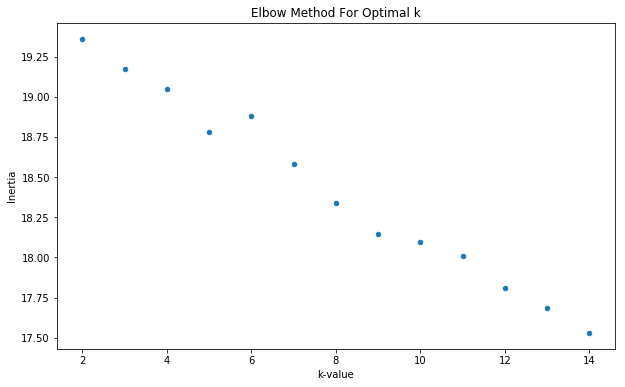

In [44]:
df_kcosts.plot(kind='scatter', x='k', y='Inertia', figsize=(10, 6))
plt.ylabel('Inertia')
plt.xlabel('k-value')
plt.title('Elbow Method For Optimal k')
plt.show()

Fit k-means

In [45]:
# set number of clusters
kclusters = 9

# run k-means clustering
kmeans = KMeans(init="k-means++", n_init=12, n_clusters=kclusters, random_state=10).fit(subway_OneHot_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 5, 5, 2, 2], dtype=int32)

Final dataframe with labels

In [46]:
subway_cluster=subway_sorted

In [47]:
subway_cluster.insert(0, 'Cluster Labels', kmeans.labels_)

In [48]:
subway_cluster

,Cluster Labels,Subway Entrance,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,103rd St & Roosevelt Ave at NE corner,Latin American Restaurant,Mexican Restaurant,Deli / Bodega,Pizza Place,Pharmacy,Food Truck,South American Restaurant,Bank,Gym,Coffee Shop
1,2,103rd St & Roosevelt Ave at SE corner,Latin American Restaurant,Mexican Restaurant,Deli / Bodega,Pizza Place,Pharmacy,Food Truck,South American Restaurant,Bank,Gym,Coffee Shop
2,2,104th St & Jamaica Ave at NE corner,Peruvian Restaurant,Deli / Bodega,Chinese Restaurant,Liquor Store,Bakery,Moving Target,Lounge,Bookstore,Park,Bagel Shop
3,2,104th St & Jamaica Ave at SE corner,Peruvian Restaurant,Deli / Bodega,Chinese Restaurant,Pharmacy,Convenience Store,Mexican Restaurant,Metro Station,Park,Bar,Market
4,2,10th Ave & 207th St at NW corner,Lounge,Pizza Place,Café,Grocery Store,Mexican Restaurant,Juice Bar,Nightclub,Food Truck,Bank,Bakery
5,2,10th Ave & 207th St at SW corner,Lounge,Pizza Place,Café,Mexican Restaurant,Grocery Store,Frozen Yogurt Shop,Bakery,Restaurant,Latin American Restaurant,Juice Bar
6,5,10th Ave & 215th St at NW corner,Café,Park,Mexican Restaurant,Cuban Restaurant,Athletics & Sports,Playground,Pizza Place,Scenic Lookout,Coffee Shop,Farmers Market
7,5,10th Ave & 215th St at SW corner,Café,Mexican Restaurant,Park,Bakery,Latin American Restaurant,Coffee Shop,Bar,Pharmacy,Scenic Lookout,Lounge
8,2,111th St & Jamaica Blvd at NE corner,Discount Store,Mexican Restaurant,Bank,Gym / Fitness Center,Lounge,Grocery Store,Bookstore,Bakery,Cosmetics Shop,Spanish Restaurant
9,2,111th St & Jamaica Blvd at SE corner,Pizza Place,Discount Store,Latin American Restaurant,Cosmetics Shop,Gym / Fitness Center,Lounge,Grocery Store,Bookstore,Bakery,Mexican Restaurant


In [49]:
dfSubwayEntrances_merged = dfSubwayEntrances
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
dfSubwayEntrances_merged = dfSubwayEntrances_merged.join(subway_cluster.set_index('Subway Entrance'), on='Subway Entrance')

dfSubwayEntrances_merged.head()

,Subway Entrance,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Birchall Ave & Sagamore St at NW corner,40.849169,-73.868356,2,Deli / Bodega,Pizza Place,Garden,Pool Hall,Park,Paper / Office Supplies Store,Hookah Bar,Moving Target,Liquor Store,Spanish Restaurant
1,Birchall Ave & Sagamore St at NE corner,40.849128,-73.868213,2,Deli / Bodega,Pizza Place,Garden,Pool Hall,Park,Paper / Office Supplies Store,Hookah Bar,Moving Target,Liquor Store,Spanish Restaurant
2,Morris Park Ave & 180th St at NW corner,40.841223,-73.873499,2,Zoo,Bus Station,Supermarket,Donut Shop,Park,Bus Stop,Dry Cleaner,Art Gallery,Diner,Fruit & Vegetable Store
4,Boston Rd & 178th St at SW corner,40.840815,-73.879623,2,Bus Station,Park,Bus Stop,Pizza Place,Supermarket,Liquor Store,Bank,Basketball Court,Metro Station,Diner
5,Boston Rd & E Tremont Ave at NW corner,40.840434,-73.880005,2,Bus Station,Pizza Place,Park,Bus Stop,Sandwich Place,Liquor Store,Supermarket,Diner,Shoe Store,Metro Station


In [50]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, cluster in zip(dfSubwayEntrances_merged['Latitude'], dfSubwayEntrances_merged['Longitude'], dfSubwayEntrances_merged['Subway Entrance'], dfSubwayEntrances_merged['Cluster Labels']):
    label = folium.Popup(str(name) + ' Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1]
    ).add_to(map_clusters)
       
map_clusters

## Clusters Analysis

In [51]:
# Number of clusters
# Positions
# value for each positions
clustersChar=getClusterCommonVenues(dfSubwayEntrances_merged,9,3,2)

For position 1 nothing found
For position 1 nothing found
For position 1 nothing found
For position 1 nothing found


In [52]:
clustersChar

,Venue Position,Venue Type,Counts,Total
Cluster Number,,,,
0,1st Most Common Venue,Bar,8,8
0,2nd Most Common Venue,Mexican Restaurant,8,8
1,1st Most Common Venue,Chinese Restaurant,7,14
1,1st Most Common Venue,Cantonese Restaurant,4,14
1,2nd Most Common Venue,Bakery,4,14
1,2nd Most Common Venue,Sushi Restaurant,4,14
2,1st Most Common Venue,Pizza Place,32,188
2,1st Most Common Venue,Deli / Bodega,24,188
2,2nd Most Common Venue,Pizza Place,28,188


In [ ]:
#cluster 0 famosa per i ristoranti messicani e bar e torna
#cluster 1 prende chinatown (maggioranza di cucina orientale e bakery)
#cluster 2 (+ numeroso). 
#cluster 3
#cluster 4
#cluster 5
#cluster 6
#cluster 7
#cluster 8 vicino broadway (teatri in maggioranza)


